# Determine water from Sentinel 2 using WOfS classifier to
* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/products/s2_l2a),

## Background


## Description

The notebook demonstrates how to:


***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import gc
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, xr_animation
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.wofsclassifier import wofs_classify

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app='water_extent_s2_classifier')

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [3]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:36847 Dashboard: /user/nanaboamah89@gmail.com/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.

The parameters are:

* `lat`: The central latitude to analyse (e.g. 10.338).
* `lon` : The central longitude to analyse (e.g. -1.055).
* `lat_buffer` : The number of degrees to load around the central latitude.
* `lon_buffer` : The number of degrees to load around the central longitude.
* `start_year` and `end_year`: The date range to analyse (e.g. `('2017', '2020')`.


**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers part of the Lake Sulunga. Tanzania. 


In [4]:
# Define the area of interest
lat = -5.9460 #-6.0873
lon =  35.5188 #35.1817

lat_buffer = 0.03
lon_buffer = 0.03

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# Define the start year and end year
start_year = '2017-02'
end_year = '2021-05'

## View the area of Interest on an interactive map
The next cell will display the selected area on an interactive map.
The red border represents the area of interest of the study.
Zoom in and out to get a better understanding of the area of interest.
Clicking anywhere on the map will reveal the latitude and longitude coordinates of the clicked point.

In [5]:
display_map(lon_range, lat_range)

## Load cloud-masked satellite data

The code below will create a query dictionary for our region of interest, and then load Sentinel-2 satellite data.
For more information on loading data, see the [Loading data notebook](../Beginners_guide/03_Loading_data.ipynb).

In [6]:
#Create a query object
query = {
    'x': lon_range,
    'y': lat_range,
    'resolution': (-20, 20),
    'output_crs':'EPSG:6933',
    'time': (start_year),
    'dask_chunks':{'time':1,'x':500,'y':500}
}

#load Sentinel 2 data
ds = load_ard(dc=dc,
             products=['s2_l2a'],
#              measurements=['b'green','swir_1'],
             mask_filters=[("opening", 3),("dilation", 2)], #improve cloud mask
             group_by='solar_day',
             **query)

print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying morphological filters to pq mask [('opening', 3), ('dilation', 2)]
Applying pixel quality/cloud mask
Returning 3 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 3, y: 382, x: 290)
Coordinates:
  * time         (time) datetime64[ns] 2017-02-08T07:57:30 ... 2017-02-28T08:...
  * y            (y) float64 -7.534e+05 -7.534e+05 ... -7.61e+05 -7.61e+05
  * x            (x) float64 3.424e+06 3.424e+06 3.424e+06 ... 3.43e+06 3.43e+06
    spatial_ref  int32 6933
Data variables: (12/15)
    B01          (time, y, x) float32 dask.array<chunksize=(1, 382, 290), meta=np.ndarray>
    B02          (time, y, x) float32 dask.array<chunksize=(1, 382, 290), meta=np.ndarray>
    B03          (time, y, x) float32 dask.array<chunksize=(1, 382, 290), meta=np.ndarray>
    B04          (time, y, x) float32 dask.array<chunksize=(1, 382, 290), meta=np.ndarray>
    B05          (time, y, x) float32 dask.array<ch

In [7]:
clean_mask = np.isin(ds['SCL'], [4,5,6,7,11])

In [8]:
ds_wofs = wofs_classify(ds, x_coord='x', y_coord='y', clean_mask=clean_mask, 
                              no_data=np.nan)

In [9]:
ds_wofs

<xarray.Dataset>
Dimensions:      (time: 3, y: 382, x: 290)
Coordinates:
  * time         (time) datetime64[ns] 2017-02-08T07:57:30 ... 2017-02-28T08:...
  * y            (y) float64 -7.534e+05 -7.534e+05 ... -7.61e+05 -7.61e+05
  * x            (x) float64 3.424e+06 3.424e+06 3.424e+06 ... 3.43e+06 3.43e+06
    spatial_ref  int32 6933
Data variables:
    wofs         (time, y, x) float64 nan nan nan nan nan ... 0.0 0.0 nan nan

In [10]:
wofl_wetnocloud = (ds_wofs.wofs==1) 
wofl_drynocloud = (ds_wofs.wofs==0)

In [11]:
ds_s2 = load_ard(dc=dc,
             products=['s2_l2a'],
             measurements=['green','swir_1'],
             mask_filters=[("opening", 3),("dilation", 2)], #improve cloud mask
             group_by='solar_day',
             **query)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying morphological filters to pq mask [('opening', 3), ('dilation', 2)]
Applying pixel quality/cloud mask
Returning 3 time steps as a dask array


In [12]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds_s2 = calculate_indices(ds=ds_s2, index='MNDWI', satellite_mission='s2', drop=True)

Dropping bands ['green', 'swir_1']


In [13]:
np.unique(wofl_wetnocloud)

array([False,  True])

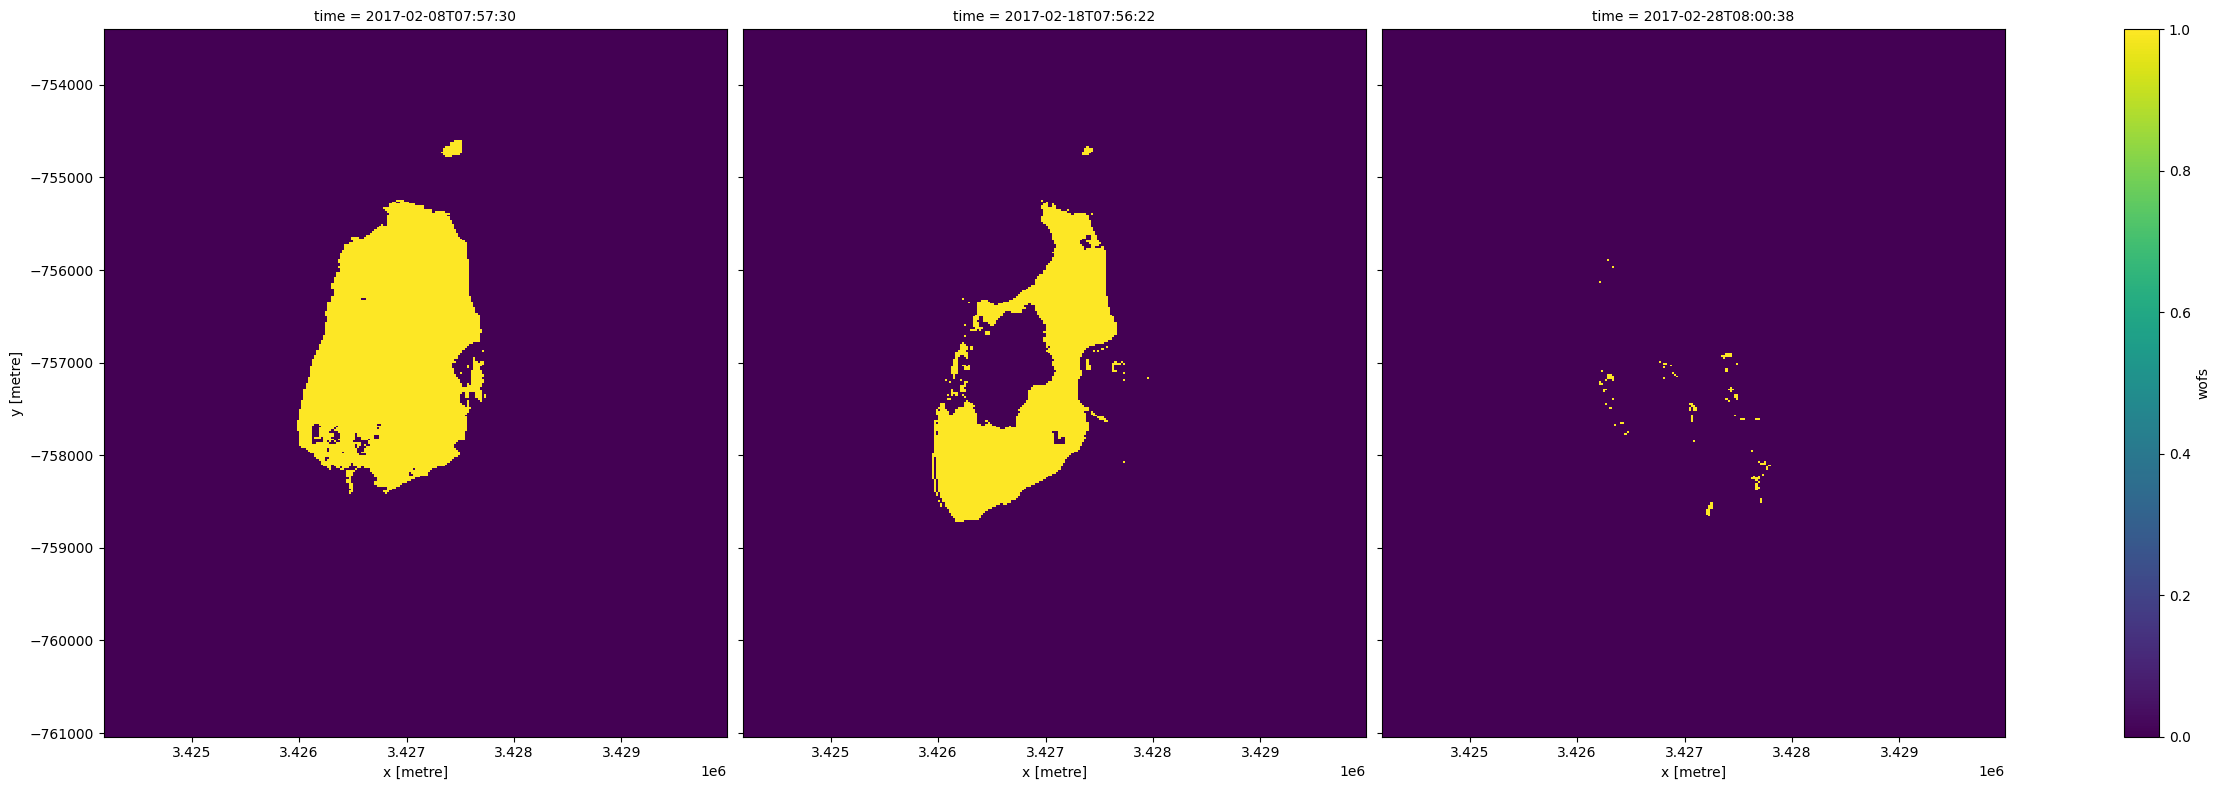

In [14]:
#'WOFS from Sentinel'
(wofl_wetnocloud).plot(col='time', size=8)
plt.show()

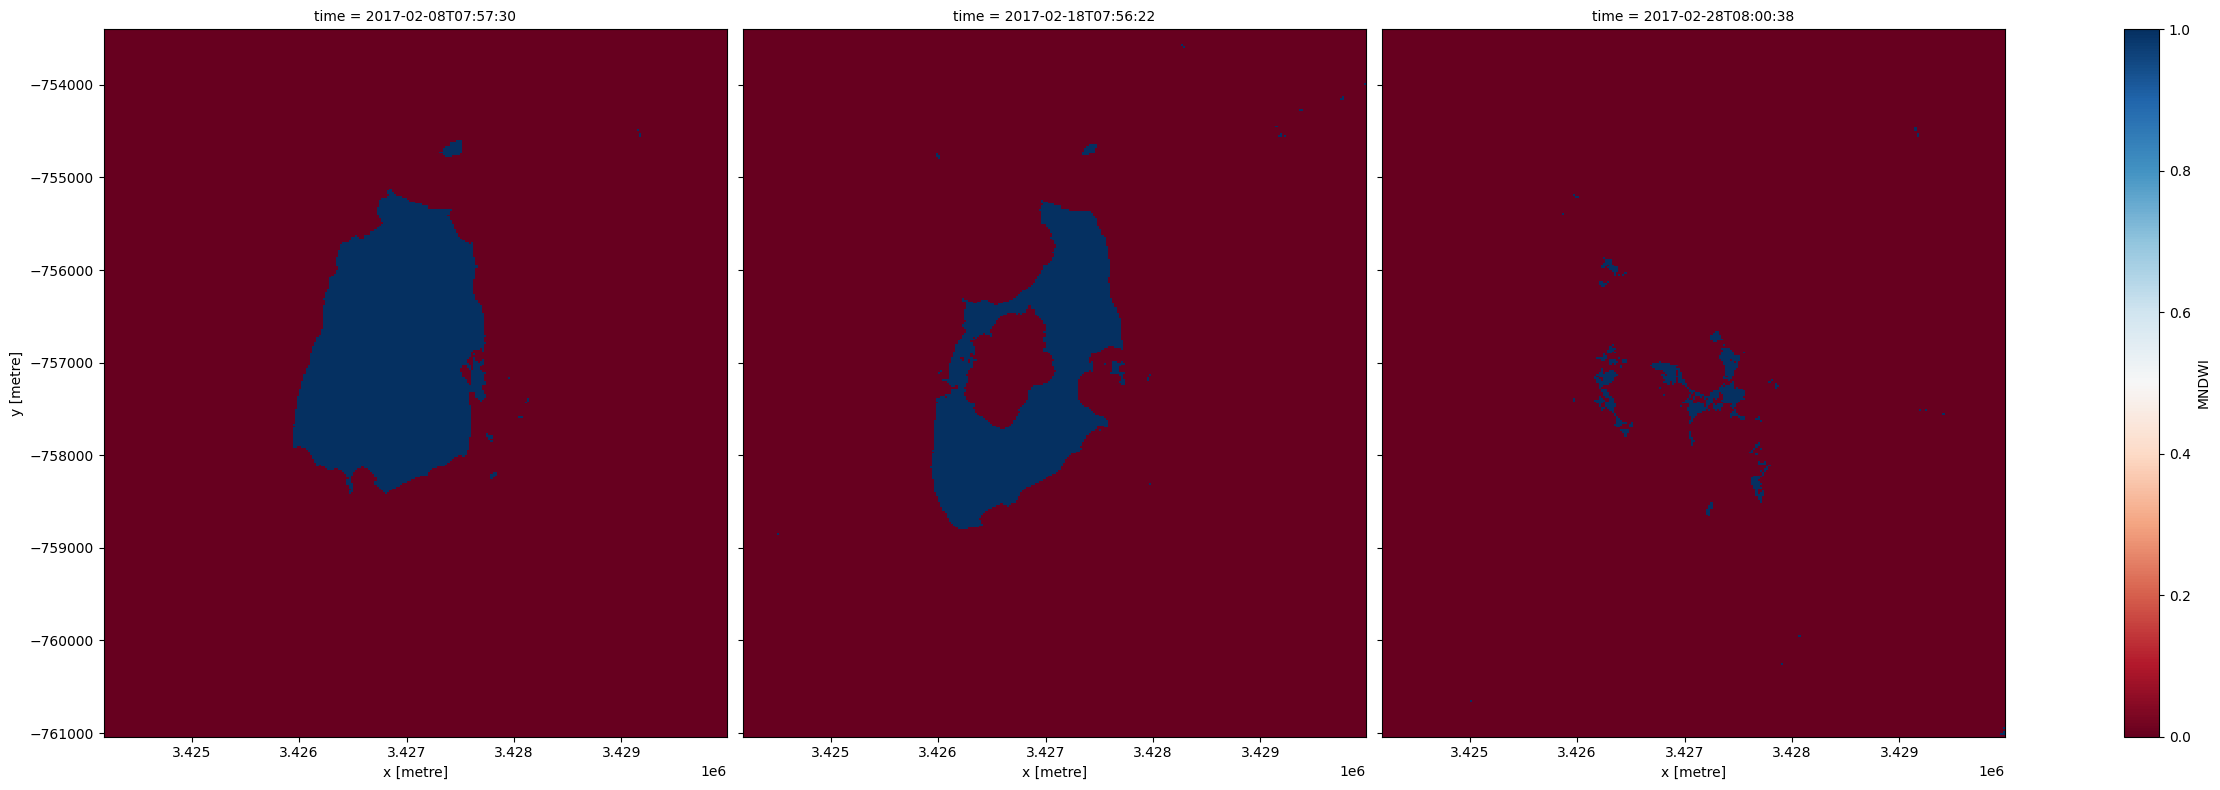

In [15]:
#MNDWI from Sentinel
(ds_s2.MNDWI > 0).plot(col='time', cmap='RdBu', size=8);
plt.show()

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [16]:
print(datacube.__version__)

1.8.8


**Last Tested:**

In [17]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-03-26'